# Data Preprocessing

## Load Data

In [1]:
import torch
import pickle

# Load raw CTs

# Load the encoded data
all_encoded_cubes = torch.load('data/generated-data/vqgan_encoded_96.pt')#data/all_encoded_cubes.pt')

# encoded_cubes_estimated_labels = torch.load('data/generated-data/seg_cubes_tensor.pt')
sampled_points_labels = torch.load('data/generated-data/sample_point_ground_truths.pt')

sampled_points_coordinates = torch.load('data/generated-data/sample_coordinates.pt')


# Load the list of patient IDs
with open('data/generated-data/filtered_ids.pkl', 'rb') as f:
    all_filtered_ids = pickle.load(f)


print(all_encoded_cubes.shape)
print(len(all_filtered_ids))
assert len(all_encoded_cubes) == len(all_filtered_ids)
assert len(sampled_points_labels) == len(all_filtered_ids)

torch.Size([44, 55, 8, 24, 24, 24])
44


/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/3472643666.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_encoded_cubes = torch.load('data/generate

In [2]:
def create_labels(n_samples=50, n_pancreas=10, n_background=45, D=24, H=24, W=24):
    """
    Create a labels tensor indicating pancreas (1) vs. background (0) for each voxel.

    Parameters:
        n_samples (int): Number of CT scans.
        n_pancreas (int): Number of pancreas points per CT scan.
        n_background (int): Number of background points per CT scan.
        D (int): Depth dimension size.
        H (int): Height dimension size.
        W (int): Width dimension size.

    Returns:
        torch.Tensor: Labels tensor of shape (n_samples * n_points * D * H * W,)
                      where n_points = n_pancreas + n_background.
    """
    # Total number of points per CT scan
    n_points = n_pancreas + n_background  # 55

    # Create labels for one CT scan: first 10 pancreas (1), next 45 background (0)
    labels_per_ct = torch.cat([
        torch.ones(n_pancreas, dtype=torch.long),
        torch.zeros(n_background, dtype=torch.long)
    ])  # Shape: [55]

    # Number of voxels per point
    n_voxels_per_point = D * H * W  # 24 * 24 * 24 = 13,824

    # Repeat each label for its corresponding voxels
    # Each point's label is repeated for all its voxels
    labels_per_voxel = labels_per_ct.repeat_interleave(n_voxels_per_point)  # Shape: [55 * 13,824]

    # Repeat for all CT scans
    labels = labels_per_voxel.repeat(n_samples)  # Shape: [50 * 55 * 13,824] = [38,016,000]

    return labels

In [3]:
labels = create_labels(
    n_samples=50,
    n_pancreas=10,
    n_background=45,
    D=24,
    H=24,
    W=24
)

print(labels.shape)

torch.Size([38016000])


## Flattening & Extracting Middle Vector

In [4]:
import torch
from typing import Optional, Tuple

def flatten_features(features: torch.Tensor) -> torch.Tensor:
    """
    Flatten the input features while keeping the dimension of 8 intact.

    Parameters:
        features (torch.Tensor): Original features of shape (n_samples, 55, 8, 24, 24, 24).

    Returns:
        torch.Tensor: Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
    """
    if not isinstance(features, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")

    # Get the shape of the input tensor
    n_samples, _, dim_8, *rest = features.shape

    # Ensure the dimension of 8 is in the correct position
    assert dim_8 == 8, "The third dimension must be 8."

    # Flatten the tensor while keeping the dimension of 8 intact
    flattened = features.permute(0, 2, 1, 3, 4, 5).contiguous().view(n_samples * 55 * 24 * 24 * 24, 8)
    
    return flattened


def unflatten_features(flattened: torch.Tensor, n_samples: int) -> torch.Tensor:
    """
    Un-flatten the input features back to their original shape.

    Parameters:
        flattened (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples.

    Returns:
        torch.Tensor: Original features of shape (n_samples, 55, 8, 24, 24, 24).
    """
    if not isinstance(flattened, torch.Tensor):
        raise TypeError("Input features must be a torch.Tensor.")
    
    # Define the expected dimensions
    num_items = 55
    num_channels = 8
    dim_size = 24
    
    # Calculate the expected size of the first dimension
    expected_first_dim = n_samples * num_items * dim_size * dim_size * dim_size
    
    if flattened.shape[0] != expected_first_dim:
        raise ValueError(
            f"First dimension of flattened tensor should be {expected_first_dim} "
            f"(n_samples * 55 * 24 * 24 * 24), but got {flattened.shape[0]}."
        )
    
    if flattened.shape[1] != num_channels:
        raise ValueError(
            f"The last dimension of flattened tensor should be {num_channels}, "
            f"but got {flattened.shape[1]}."
        )
    
    # Reshape to (n_samples, 55, 24, 24, 24, 8)
    reshaped = flattened.view(n_samples, num_items, dim_size, dim_size, dim_size, num_channels)
    
    # Permute to (n_samples, 55, 8, 24, 24, 24)
    original = reshaped.permute(0, 1, 5, 2, 3, 4).contiguous()
    
    return original


def extract_middle_vectors(flattened_features: torch.Tensor,
                           n_samples: int = all_encoded_cubes.shape[0],
                           n_j: int = 55,
                           n_x: int = 24,
                           n_y: int = 24,
                           n_z: int = 24,
                           middle_x: int = 12,
                           middle_y: int = 12,
                           middle_z: int = 12) -> (torch.Tensor, torch.Tensor):
    """
    Extract the middle vectors at position (i, j, 12, 12, 12, :) from the flattened tensor
    and return their corresponding indices.

    Parameters:
        flattened_features (torch.Tensor): Flattened features of shape (n_samples * 55 * 24 * 24 * 24, 8).
        n_samples (int): Number of samples (e.g., 50).
        n_j (int): Size of the second dimension (e.g., 55).
        n_x (int): Size of the third dimension (e.g., 24).
        n_y (int): Size of the fourth dimension (e.g., 24).
        n_z (int): Size of the fifth dimension (e.g., 24).
        middle_x (int): Middle index along the x-axis (e.g., 12).
        middle_y (int): Middle index along the y-axis (e.g., 12).
        middle_z (int): Middle index along the z-axis (e.g., 12).

    Returns:
        middle_vectors (torch.Tensor): Middle vectors of shape (n_samples * n_j, 8).
        indices (torch.Tensor): Indices of the middle vectors in the flattened tensor, shape (n_samples * n_j,).
    """
    def compute_middle_indices(n_samples: int, n_j: int, n_x: int, n_y: int, n_z: int,
                              middle_x: int, middle_y: int, middle_z: int) -> torch.Tensor:
        # Create tensors for i and j indices
        i_indices = torch.arange(n_samples).unsqueeze(1)  # Shape: (n_samples, 1)
        j_indices = torch.arange(n_j).unsqueeze(0)        # Shape: (1, n_j)

        # Calculate strides based on the permutation and flattening
        stride_j = n_x * n_y * n_z  # Stride for j dimension
        stride_x = n_y * n_z        # Stride for x dimension
        stride_y = n_z              # Stride for y dimension
        stride_z = 1                # Stride for z dimension

        # Compute the flattened indices using the formula:
        # index = i * (55 * 24 * 24 * 24) + j * (24 * 24 * 24) + 12 * (24 * 24) + 12 * 24 + 12
        indices = (i_indices * (n_j * stride_j) +
                   j_indices * stride_j +
                   middle_x * stride_x +
                   middle_y * stride_y +
                   middle_z * stride_z).view(-1)  # Shape: (n_samples * n_j,)

        return indices

    # Compute the indices for the middle vectors
    indices = compute_middle_indices(n_samples, n_j, n_x, n_y, n_z, middle_x, middle_y, middle_z)

    # Ensure that the indices are within the bounds of the flattened tensor
    if torch.any(indices >= flattened_features.shape[0]):
        raise IndexError("Computed indices are out of bounds.")

    # Extract the middle vectors using the computed indices
    middle_vectors = flattened_features[indices]  # Shape: (n_samples * n_j, 8)

    return middle_vectors, indices

In [5]:
all_encoded_cubes.shape

torch.Size([44, 55, 8, 24, 24, 24])

In [6]:
# Flatten the features
flattened_features = flatten_features(all_encoded_cubes)
print(flattened_features.shape)

torch.Size([33454080, 8])


In [7]:
50*55*24*24*24

38016000

In [8]:
import pandas as pd

full_data_df = pd.DataFrame(flattened_features)

In [9]:
full_data_df.describe()

,0,1,2,3,4,5,6,7
count,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07
mean,2.588828e-02,2.505811e-02,2.407135e-02,2.397419e-02,2.272335e-02,2.191160e-02,2.210585e-02,1.586046e-02
std,2.790734e+00,2.796249e+00,2.802558e+00,2.819213e+00,2.850300e+00,2.898558e+00,2.969976e+00,3.067125e+00
min,-7.282210e+01,-7.883923e+01,-7.534063e+01,-7.808358e+01,-6.891394e+01,-7.039552e+01,-8.614471e+01,-9.924159e+01
25%,-1.050005e+00,-1.057693e+00,-1.064493e+00,-1.071974e+00,-1.082215e+00,-1.092725e+00,-1.103266e+00,-1.118634e+00
50%,-5.195173e-02,-5.574355e-02,-5.933185e-02,-6.293696e-02,-6.727543e-02,-6.980651e-02,-7.094030e-02,-7.654586e-02
75%,1.128515e+00,1.135685e+00,1.144067e+00,1.154422e+00,1.166500e+00,1.181320e+00,1.198815e+00,1.213556e+00
max,7.215614e+01,6.032399e+01,6.103173e+01,8.505675e+01,6.688710e+01,6.302858e+01,6.105354e+01,6.553908e+01


Data is pretty much mean 0, but variance is slightly too high. Let's normalize

In [10]:
from sklearn.preprocessing import StandardScaler

scaled_data_df = pd.DataFrame(StandardScaler().fit_transform(full_data_df))

scaled_data_df.describe()

,0,1,2,3,4,5,6,7
count,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07,3.345408e+07
mean,-5.778020e-09,-2.198457e-10,-1.770625e-09,-7.213403e-10,3.677399e-09,-5.700481e-09,-8.301228e-11,4.318919e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.610352e+01,-2.820360e+01,-2.689140e+01,-2.770544e+01,-2.418576e+01,-2.429396e+01,-2.901262e+01,-3.236173e+01
25%,-3.855234e-01,-3.872156e-01,-3.884181e-01,-3.887426e-01,-3.876570e-01,-3.845487e-01,-3.789159e-01,-3.698885e-01
50%,-2.789231e-02,-2.889645e-02,-2.975967e-02,-3.082817e-02,-3.157521e-02,-3.164267e-02,-3.132892e-02,-3.012799e-02
75%,3.951029e-01,3.971846e-01,3.996333e-01,4.009798e-01,4.012829e-01,3.999948e-01,3.962016e-01,3.904947e-01
max,2.584634e+01,2.156422e+01,2.176856e+01,3.016188e+01,2.345872e+01,2.173725e+01,2.054947e+01,2.136308e+01


# Apply PCA w/o Reducing # Components

In [11]:
from sklearn.decomposition import PCA

In [12]:
# Damn, before I forgot to Scale data before PCA

full_data_df = scaled_data_df

In [13]:
full_pca = PCA().fit(full_data_df)

full_pca.explained_variance_

array([4.669881  , 1.2227737 , 0.6579927 , 0.4332105 , 0.32542312,
       0.26480326, 0.22618966, 0.19974478], dtype=float32)

In [14]:
full_pca_data = full_pca.transform(full_data_df)

In [15]:
df_pca = pd.DataFrame(full_pca_data, columns=[f'PC{i+1}' for i in range(8)])
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-3.229365,-0.315056,0.217194,1.134532,-0.234048,-0.197323,0.483030,-0.195266
1,-0.840130,0.316924,-0.816894,-0.033873,-0.180691,-1.009421,0.470564,0.265241
2,-1.446965,-0.238159,-0.004309,0.094242,0.100495,0.247716,0.005195,0.038418
3,-3.458071,-0.640564,0.864171,0.356804,-0.336126,0.221462,0.746964,1.167398
4,0.453954,0.380781,-0.015072,0.671849,1.218144,-0.346029,0.277618,-0.011094
...,...,...,...,...,...,...,...,...
33454075,0.596478,0.000406,0.186836,-0.326358,-0.255047,0.180830,-0.078529,-0.177241
33454076,0.502552,0.248897,-0.303216,-0.630018,-0.614256,-0.421677,0.279238,-0.169726
33454077,0.245332,-0.086342,0.185171,-0.144138,0.076661,0.072822,0.055678,-0.025180
33454078,0.640185,0.070506,-0.269344,0.358639,-0.289507,-0.524066,0.040580,0.056884


In [16]:
# df_pca = df_pca.reset_index(drop=True)

# df_pca.reset_index(drop=True)['Labels'] = labels

### Explained Variance Plot

Text(0.5, 1.0, 'Explained Variance Ratio by Components')

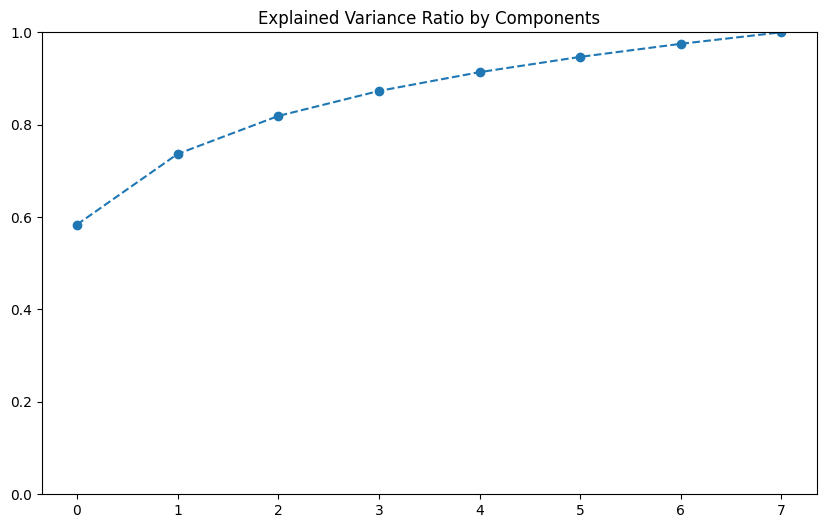

In [17]:
# plot that as scree plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(full_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

plt.ylim(0, 1)

plt.title('Explained Variance Ratio by Components')

In [18]:
full_pca_data.shape

(33454080, 8)

In [19]:
middle_vectors, _ = extract_middle_vectors(torch.Tensor(full_pca_data))

middle_vectors.shape

torch.Size([2420, 8])

In [20]:
cluster_labels_mini10, _ = extract_middle_vectors(torch.Tensor(labels).unsqueeze(1))

In [21]:
cluster_labels_mini10.shape

torch.Size([2420, 1])

In [22]:
middle_vectors_df = pd.DataFrame(middle_vectors.numpy(), columns=[f'PC{i+1}' for i in range(8)])
middle_vectors_df['Labels'] = cluster_labels_mini10.numpy()

middle_vectors_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Labels
0,-0.596444,0.748027,-0.939316,-1.247319,0.170320,0.053216,0.204649,-0.093907,1
1,-1.303668,-0.280617,-0.046170,-0.057345,0.217235,-0.154440,-0.195700,0.036580,1
2,0.952006,-0.524271,0.462724,0.291812,-0.016711,0.189469,-0.176747,0.196354,1
3,0.312273,-0.112056,0.233341,0.099305,-0.057175,-0.058717,0.018856,0.020439,1
4,0.671716,-0.349971,0.171580,-0.001066,0.408654,0.048408,-0.065902,-0.031181,1
...,...,...,...,...,...,...,...,...,...
2415,-0.193587,0.041998,0.042401,0.115989,0.219584,0.353304,0.035662,-0.176940,0
2416,1.320382,0.958956,-0.050256,-0.015377,-0.287837,-1.046572,-1.747166,2.095311,0
2417,-0.374726,0.890128,-0.141552,0.241234,0.513711,0.123783,-0.008209,-0.075693,0
2418,0.046051,0.435326,-0.116633,-0.376649,0.289182,0.081530,-0.009154,0.118637,0


In [23]:
pd.DataFrame(middle_vectors.numpy()).value_counts()

0           1          2          3          4          5          6          7        
-13.789174   0.083209   0.839944  -0.003628   0.238826  -0.102154  -0.161314  -0.069529    1
 0.406395   -0.431661   0.998399  -0.878910  -0.167503   0.941270   0.375858  -0.264463    1
 0.407440    0.182159  -0.066437  -0.400526   0.289200   0.039890   0.170227   0.142934    1
 0.407563    0.232815   0.010011  -0.032456  -0.060542   0.113205  -0.111322  -0.005041    1
 0.407709    0.160821   0.002097  -0.030187  -0.032791  -0.025278   0.023655  -0.014515    1
                                                                                          ..
-0.500113   -0.022919   0.005384   0.034563  -0.035311  -0.132795   0.060884   0.024574    1
-0.498921    0.056568  -0.236215  -0.213788  -0.470205  -0.603860   0.399182  -0.210550    1
-0.498026   -0.107268   0.204937  -0.090852   0.176524   0.021152   0.036783   0.161539    1
-0.497989    0.913492   0.076071  -0.069438   0.032885  -0.086609   0.16102

# Cluster

### Function Definitions 📚

In [24]:
#### Function Definitions 📚
import pandas as pd
import dask.dataframe as dd
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, Birch
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

def calculate_purities(data, labels, algorithms, plot=True):
    """
    Calculate purity ratios for multiple clustering algorithms.

    Parameters:
    - data: array-like, shape (n_samples, n_features)
        The data to cluster.
    - labels: array-like, shape (n_samples,)
        The true labels.
    - algorithms: list of tuples (name, estimator)
        Each tuple contains a unique name for the algorithm and an instance of a clustering estimator.
    - plot: bool, default=True
        Whether to plot purity ratios.

    Returns:
    - pd.DataFrame: A DataFrame containing purity counts and ratios per cluster for each algorithm.
    """
    results = []

    # Wrap the algorithms list with tqdm for a progress bar
    for name, estimator in tqdm(algorithms, desc="Clustering Algorithms", unit="alg"):
        # Fit the clustering algorithm
        estimator.fit(data)
        
        # Obtain cluster labels
        if hasattr(estimator, 'labels_'):
            cluster_labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            cluster_labels = estimator.predict(data)
        else:
            raise AttributeError(f"The estimator {name} does not have 'labels_' or 'predict' method.")

        # Create DataFrame with data, cluster labels, and true labels
        df = pd.DataFrame(data, columns=[f'Feature_{i+1}' for i in range(data.shape[1])])
        df = df.reset_index(drop=True)
        df['Cluster'] = cluster_labels
        df['Labels'] = labels

        # Convert to Dask DataFrame
        if isinstance(df, pd.DataFrame):
            df_dd = dd.from_pandas(df, npartitions=4)  # Fixed number of partitions
        else:
            df_dd = df  # Assume already a Dask DataFrame

        # Convert columns to categorical for memory efficiency
        df_dd['Cluster'] = df_dd['Cluster'].astype('category')
        df_dd['Labels'] = df_dd['Labels'].astype('category')

        # Persist the DataFrame (cache in memory)
        df_dd = df_dd.persist()

        # Group by 'Cluster' and 'Labels' and count
        counts = df_dd.groupby(['Cluster', 'Labels']).size()
        
        # Trigger computation to get a pandas Series
        counts_pd = counts.compute()
        
        # Unstack the multi-index Series into a DataFrame
        cluster_label_counts = counts_pd.unstack(fill_value=0)
        
        # Calculate ratios
        cluster_label_ratio = cluster_label_counts.div(cluster_label_counts.sum(axis=1), axis=0)
        
        # Rename columns for clarity
        cluster_label_counts.columns = [f'Count_Label_{col}' for col in cluster_label_counts.columns]
        cluster_label_ratio.columns = [f'Ratio_Label_{col}' for col in cluster_label_ratio.columns]
        
        # Combine counts and ratios
        purity_df = pd.concat([cluster_label_counts, cluster_label_ratio], axis=1).reset_index()
        purity_df['Algorithm'] = name

        # Optionally, extract n_clusters if available
        if hasattr(estimator, 'n_clusters'):
            purity_df['n_clusters'] = estimator.n_clusters
        else:
            purity_df['n_clusters'] = None

        # Append to results
        results.append(purity_df)

    # Concatenate all results into a single DataFrame
    final_df = pd.concat(results, ignore_index=True)

    # Optional Plotting
    if plot:
        for algo in final_df['Algorithm'].unique():
            algo_df = final_df[final_df['Algorithm'] == algo].copy()
            algo_df.set_index('Cluster', inplace=True)
            
            # Identify ratio columns
            ratio_cols = [col for col in algo_df.columns if col.startswith('Ratio_Label_')]
            
            # Plotting the stacked bar chart
            ax = algo_df[ratio_cols].plot(
                kind='bar',
                stacked=True,
                figsize=(12, 8),
                edgecolor='black',
                title=f'Purity Ratios per Cluster for {algo}'
            )
            
            # Adding labels and title
            ax.set_xlabel('Cluster', fontsize=14)
            ax.set_ylabel('Purity Ratio', fontsize=14)
            ax.legend(title='Labels')
            
            # Displaying the plot
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()
            
            # Reset index for potential further use
            algo_df.reset_index(inplace=True)

    return final_df

## Running on All Flattened Data

### KMeans for range(2, 100, 2) Clusters

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans#, Birch - too slow
import hdbscan  # Optional, if you decide to use HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 102, 2)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    # MiniBatchKMeans
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init=10  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=full_pca_data,
    labels=labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

In [ ]:
count_zeros = (labels == 0).sum().item()
count_ones = (labels == 1).sum().item()

print(count_zeros, count_ones)

print(count_zeros / len(labels), count_ones / len(labels))

### OPTICS

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import OPTICS

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'OPTICS_{n_clusters}'
    mbk = OPTICS(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

### HDBSCAN

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from hdbscan import HDBSCAN

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'hdbscan_{n_clusters}'
    mbk = HDBSCAN(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=middle_vectors,
    labels=cluster_labels_mini10,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

## Running only on single Flattened CTs

In [112]:
first_encoded_ct = all_encoded_cubes[0]
first_ct_flattened = flatten_features(first_encoded_ct.unsqueeze(0))

first_ct_data = first_ct_flattened.numpy()

In [ ]:
first_ct_data.shape

In [89]:
first_ct_labels = create_labels(
    n_samples=1,
    n_pancreas=10,
    n_background=45,
    D=24,
    H=24,
    W=24
).numpy()

### KMeans for range(2, 100, 2) Clusters

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import MiniBatchKMeans

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(2, 51, 1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'MiniBatchKMeans_n{n_clusters}'
    mbk = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=42,
        batch_size=10000,
        init='k-means++',  # You can adjust initialization if needed
        n_init='auto'  # Number of initializations to perform
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=data,
    labels=first_ct_labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

### OPTICS

In [ ]:
import warnings

# Suppress only the specific FutureWarning about 'observed'
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas."
)


from sklearn.cluster import OPTICS

# Initialize an empty list to hold all algorithm configurations
algorithms = []

cluster_range = range(0,1)

# Loop through the cluster range to create MiniBatchKMeans and Birch instances
for n_clusters in cluster_range:
    mbk_name = f'OPTICS_{n_clusters}'
    mbk = OPTICS(
    )
    algorithms.append((mbk_name, mbk))


# Calculate purities
purity_results = calculate_purities(
    data=first_ct_data,
    labels=first_ct_labels,
    algorithms=algorithms,
    plot=True  # Set to False if you don't want plots
)

# Display the results
purity_results

## Pairwise Similarities

### Between Middle Vectors

In [72]:
import numpy as np


def compute_cosine_similarity(matrix):
    """
    Compute the pairwise cosine similarity matrix for a 2D NumPy array.

    Parameters:
    - matrix (np.ndarray): A 2D NumPy array of shape (n_samples, n_features).

    Returns:
    - cosine_sim_matrix (np.ndarray): A 2D NumPy array of shape (n_samples, n_samples) containing cosine similarities.
    """
    # Step 1: Normalize the matrix
    # Add a small epsilon to avoid division by zero
    norm = np.linalg.norm(matrix, axis=1, keepdims=True) + 1e-10
    normalized_matrix = matrix / norm

    # Step 2: Compute cosine similarity as dot product of normalized vectors
    cosine_sim_matrix = np.dot(normalized_matrix, normalized_matrix.T)

    return cosine_sim_matrix

In [73]:
middle_vector_dot_products = torch.mm(middle_vectors, middle_vectors.T)

In [76]:
middle_vector_cosines = compute_cosine_similarity(middle_vectors.numpy())

In [ ]:
middle_vector_dot_products

In [ ]:
pd.DataFrame(middle_vector_dot_products.numpy()).describe()

In [ ]:
pd.DataFrame(middle_vector_cosines).describe()

In [ ]:
plt.imshow(middle_vector_cosines, cmap='hot')#, interpolation='nearest')

### Between Vectors within same CT

In [ ]:
first_encoded_ct = all_encoded_cubes[0]

first_encoded_ct.shape

In [ ]:
first_ct_flattened = flatten_features(first_encoded_ct.unsqueeze(0))

first_ct_flattened.shape

## Check for Repeat/High Similarity Vectors

Do this for within a CT scan

- [] TODO

In [38]:
import numpy as np

res, counts = np.unique(full_pca_data, axis=0, return_counts=True)

In [ ]:
counts

In [ ]:
pd.DataFrame(counts).value_counts()

In [ ]:
full_data_df.value_counts()

# Plotting 🗾

### Function Definitions (Long) 📚

Functions for:

- Plotting 2D, with labels and cluster centroids
- Plotting 3D, with labels and cluster centroids
- 3D Interactive plot of the same
- Saving to ITK-SNAP landmarks

In [80]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import colormaps  # Import the correct module for colormaps

organs_dict = {
    'unlabeled/background': 0,
    'aorta': 1,
    'gall_bladder': 2,
    'spleen': 3,
    'stomach': 4,
    'kidney_right': 5,
    'kidney_left': 6,
    'liver': 7,
    'pancreas': 8,
    'postcava': 9
}

reverse_organs_dict = {v: k for k, v in organs_dict.items()}

# Function to plot 2D scatter plot with annotations and cluster centroids with variance ellipses
def plot_2d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 2D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth label numbers.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    
    # Perform PCA to reduce to 2D
    features_2d = features_high_dim
    if features_high_dim.shape[1] > 2:
        pca_2d = PCA(n_components=2)
        features_2d = pca_2d.fit_transform(features_high_dim)
    
    plt.figure(figsize=(12, 8))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Using 'tab10' colormap for up to 10 colors

    # Create a color for each label
    label_colors = {label: colors(i) for i, label in enumerate(unique_labels)}
    point_colors = [label_colors[label] for label in labels]
    
    # Create a reverse mapping for hover information
    label_names = [reverse_organs_dict.get(label, f'Label {label}') for label in labels]
    
    # Plot data points
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=point_colors, s=50, alpha=0.7)

    # Add hover information (using mplcursors for interactivity)
    try:
        import mplcursors
        cursor = mplcursors.cursor(scatter, hover=True)
        cursor.connect("add", lambda sel: sel.annotation.set_text(label_names[sel.index]))
    except ImportError:
        print("mplcursors is not installed. Hover functionality is disabled.")

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Compute and plot centroids and variance ellipses
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')

    used_colors = {}
    centroid_labels = []

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_2d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        covariance = np.cov(cluster_points, rowvar=False)
        
        if covariance.shape == (2, 2):
            eigenvalues, eigenvectors = np.linalg.eigh(covariance)
            
            # Sort eigenvalues and eigenvectors
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            
            # Compute angle for the ellipse
            angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
            
            # Width and height are "full" widths, so multiply by 2
            width, height = 2 * np.sqrt(eigenvalues)
            
            # Create and add the ellipse patch
            ellipse = Ellipse(xy=centroid, width=width, height=height, angle=angle,
                              edgecolor=cmap(i), facecolor='none', linewidth=2)
            plt.gca().add_patch(ellipse)
        
        # Plot centroid as 'X'
        plt.scatter(centroid[0], centroid[1], marker='X', s=200, c=[cmap(i)], label='Centroid')
        used_colors['Centroid'] = cmap(i)
        centroid_labels.append('Centroid')

    # Create legend for ground truth labels
    label_handles = [
        plt.Line2D([0], [0], marker='o', color='w', label=reverse_organs_dict.get(label, f'Label {label}'),
                   markerfacecolor=color, markersize=10) 
        for label, color in label_colors.items()
    ]

    # Create legend for centroids
    centroid_handles = [
        plt.Line2D([0], [0], marker='X', color='w', label='Centroid',
                   markerfacecolor=used_colors['Centroid'], markersize=10)
    ]

    # Combine both legends
    plt.legend(handles=label_handles + centroid_handles, loc='best')
    plt.grid(True)
    plt.show()        
# Function to plot 3D scatter plot with annotations and cluster centroids
def plot_3d(features_high_dim, labels, patient_ids, clusters, title):
    """
    Plots a 3D PCA scatter plot with data points colored by ground truth labels and cluster centroids.

    Parameters:
    - features_high_dim: NumPy array of shape (n_samples, n_features), original high-dimensional data.
    - labels: List or array of ground truth labels.
    - patient_ids: List of patient ID strings.
    - clusters: NumPy array of cluster assignments.
    - title: Title of the plot.
    """
    # Perform PCA to reduce to 3D
    features_3d = features_high_dim
    if features_high_dim.shape[1] > 3:
        pca_3d = PCA(n_components=3)
        features_3d = pca_3d.fit_transform(features_high_dim)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define colors for labels
    label_colors = {0: 'blue', 1: 'red'}
    colors = [label_colors[label] for label in labels]
    
    # Plot data points
    scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2],
                         c=colors, s=50, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

    # Add annotations for patient IDs
    # Annotations in 3D are more cluttered, so we skip them for now
    # for i, patient_id in enumerate(patient_ids):
        # ax.text(features_3d[i, 0], features_3d[i, 1], features_3d[i, 2], patient_id, size=8, alpha=0.6)
    
    # Compute and plot centroids
    unique_clusters = np.unique(clusters)
    cmap = colormaps.get_cmap('tab10')  # Use the new colormap API without the 'lut' parameter

    for i, cluster in enumerate(unique_clusters):
        cluster_points = features_3d[clusters == cluster]
        if cluster_points.shape[0] == 0:
            continue  # Skip empty clusters
        centroid = cluster_points.mean(axis=0)
        # Plot centroid
        ax.scatter(centroid[0], centroid[1], centroid[2], marker='X', s=200, c=[cmap(i)], label=f'Centroid {cluster}')

    # Create legend for labels
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=10) for label, color in label_colors.items()]
    
    # Create legend for centroids
    centroid_handles = [plt.Line2D([0], [0], marker='X', color='w', label=f'Centroid {cluster}',
                                   markerfacecolor=cmap(i), markersize=10) for i, cluster in enumerate(unique_clusters)]
    
    # Combine both legends
    ax.legend(handles=handles + centroid_handles, loc='best')
    plt.show()


import plotly.graph_objs as go
import plotly.express as px
import numpy as np
from typing import Optional, Tuple

def plot_interactive_3d_scatter(
    coordinates: np.ndarray,
    cluster_labels: np.ndarray,
    ground_truth_labels: Optional[np.ndarray] = None,
    axis_range: Optional[Tuple[int, int, int]] = (512, 512, 512),
    title: str = "Interactive 3D Scatter Plot",
    show_legend: bool = True
):
    """
    Plots an interactive 3D scatter plot with detailed legends for each ground truth organ and cluster centroids.

    Parameters:
    - coordinates (np.ndarray): Array of shape (n, 3) representing 3D coordinates.
    - cluster_labels (np.ndarray): Array of shape (n,) containing cluster assignments for each point.
    - ground_truth_labels (Optional[np.ndarray]): Array of shape (n,) containing ground truth labels for each point.
    - axis_range (Optional[Tuple[int, int, int]]): Tuple specifying the max range for x, y, z axes. Defaults to (512, 512, 512).
    - title (str): Title of the plot.
    - show_legend (bool): Whether to display the legend.

    Returns:
    - A Plotly Figure object displaying the interactive 3D scatter plot.
    """

    # Validate input dimensions
    if coordinates.ndim != 2 or coordinates.shape[1] != 3:
        raise ValueError("Coordinates array must be of shape (n, 3).")

    n_points = coordinates.shape[0]

    if cluster_labels.ndim != 1 or cluster_labels.shape[0] != n_points:
        raise ValueError("cluster_labels must be a 1D array with the same length as coordinates.")

    if ground_truth_labels is not None:
        if ground_truth_labels.ndim != 1 or ground_truth_labels.shape[0] != n_points:
            raise ValueError("ground_truth_labels must be a 1D array with the same length as coordinates.")

    # Extract X, Y, Z coordinates
    x = coordinates[:, 0]
    y = coordinates[:, 1]
    z = coordinates[:, 2]

    # Identify unique ground truth labels
    if ground_truth_labels is not None:
        unique_gt = np.unique(ground_truth_labels)
        num_gt = len(unique_gt)
        gt_color_palette = px.colors.qualitative.Light24
        if num_gt > len(gt_color_palette):
            extended_gt_palette = gt_color_palette * (num_gt // len(gt_color_palette) + 1)
        else:
            extended_gt_palette = gt_color_palette
        gt_colors = {gt: extended_gt_palette[i] for i, gt in enumerate(unique_gt)}
    else:
        gt_colors = {}

    # Create traces for ground truth labels
    data = []
    if ground_truth_labels is not None:
        for gt in unique_gt:
            organ_name = reverse_organs_dict.get(int(gt), f'Label {gt}')
            indices = np.where(ground_truth_labels == gt)[0]
            trace = go.Scatter3d(
                x=x[indices],
                y=y[indices],
                z=z[indices],
                mode='markers',
                marker=dict(
                    size=5,
                    color=gt_colors[gt],
                    opacity=0.8
                ),
                name=organ_name,
                hovertemplate=
                    "<b>Organ:</b> %{text}<br>" +
                    "<b>X:</b> %{x:.2f}<br>" +
                    "<b>Y:</b> %{y:.2f}<br>" +
                    "<b>Z:</b> %{z:.2f}<br>" +
                    "<extra></extra>",
                text=[organ_name] * len(indices)
            )
            data.append(trace)
    else:
        # If no ground truth labels, plot all points with a single color
        trace = go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            marker=dict(
                size=5,
                color='blue',
                opacity=0.8
            ),
            name='Data Points',
            hovertemplate=
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
        )
        data.append(trace)

    # Calculate and plot centroids as 'X'
    unique_clusters = np.unique(cluster_labels)
    num_clusters = len(unique_clusters)
    color_palette = px.colors.qualitative.Dark24
    if num_clusters > len(color_palette):
        extended_palette = color_palette * (num_clusters // len(color_palette) + 1)
    else:
        extended_palette = color_palette
    cluster_colors = {cluster: extended_palette[i] for i, cluster in enumerate(unique_clusters)}

    centroids = []
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        if len(indices) == 0:
            continue
        centroid = coordinates[indices].mean(axis=0)
        centroids.append({
            'cluster': cluster,
            'x': centroid[0],
            'y': centroid[1],
            'z': centroid[2],
            'color': cluster_colors[cluster]
        })

    if centroids:
        centroid_trace = go.Scatter3d(
            x=[c['x'] for c in centroids],
            y=[c['y'] for c in centroids],
            z=[c['z'] for c in centroids],
            mode='markers',
            marker=dict(
                size=8,
                color=[c['color'] for c in centroids],
                symbol='x',
                line=dict(width=2),
                opacity=1.0
            ),
            name='Centroids',
            hovertemplate=
                "<b>Centroid of Cluster:</b> %{text}<br>" +
                "<b>X:</b> %{x:.2f}<br>" +
                "<b>Y:</b> %{y:.2f}<br>" +
                "<b>Z:</b> %{z:.2f}<br>" +
                "<extra></extra>",
            text=[f'Cluster {c["cluster"]}' for c in centroids]
        )
        data.append(centroid_trace)

    # Define layout with customizable axis ranges
    layout = go.Layout(
        title=title,
        scene=dict(
            xaxis=dict(title='X', range=[0, axis_range[0]]),
            yaxis=dict(title='Y', range=[0, axis_range[1]]),
            zaxis=dict(title='Z', range=[0, axis_range[2]]),
        ),
        legend=dict(
            itemsizing='constant',
            title="Organ Labels",
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        showlegend=show_legend
    )

    fig = go.Figure(data=data, layout=layout)
    fig.show()

In [25]:
import xml.etree.ElementTree as ET

def save_clusters_as_annot_all_planes(points, clusters, base_dir="data/generated-data/clustering-results", filename='annotations.annot', slice_range=10, image_size=512):
    """
    Saves 3D points as annotations on multiple slices in an .annot file for ITK-SNAP.

    Parameters:
    - points (np.ndarray): Array of shape (n_points, 3) containing x, y, z coordinates.
    - clusters (np.ndarray): Array of shape (n_points,) containing cluster labels (integers).
    - filename (str): Output filename for the .annot file.
    - slice_range (int): Number of slices above and below the point to create annotations.
    - image_size (int or tuple): Size of the image (assumed cubic if int, or specify (x_size, y_size, z_size)).
    """
    if points.shape[0] != clusters.shape[0]:
        raise ValueError("Number of points and clusters must be the same.")

    n_points = points.shape[0]

    # Define fixed red color for all annotations
    color = "1 0 0"  # Fully red

    # Initialize XML structure
    registry = ET.Element('registry')

    # Add header entries
    ET.SubElement(registry, 'entry', key="Format", value="ITK-SNAP Annotation File")
    ET.SubElement(registry, 'entry', key="FormatDate", value="20241014")  # FormatDate as YYYYMMDD

    # Annotations folder
    annotations_folder = ET.SubElement(registry, 'folder', key="Annotations")
    element_counter = 0  # To keep track of Element[n] keys

    # Determine image dimensions
    if isinstance(image_size, int):
        x_max = y_max = z_max = image_size
    elif isinstance(image_size, tuple) and len(image_size) == 3:
        x_max, y_max, z_max = image_size
    else:
        raise ValueError("image_size must be an int or a tuple of three ints.")

    for i in range(n_points):
        x, y, z = points[i]
        cluster = clusters[i]

        # For each plane
        for plane in range(3):
            if plane == 0:  # Sagittal plane (X axis)
                coord = int(round(x))
                coord_min = max(0, coord - slice_range)
                coord_max = min(x_max - 1, coord + slice_range)
            elif plane == 1:  # Coronal plane (Y axis)
                coord = int(round(y))
                coord_min = max(0, coord - slice_range)
                coord_max = min(y_max - 1, coord + slice_range)
            elif plane == 2:  # Axial plane (Z axis)
                coord = int(round(z))
                coord_min = max(0, coord - slice_range)
                coord_max = min(z_max - 1, coord + slice_range)

            # Loop over the coordinate range
            for c in range(coord_min, coord_max + 1):
                element_key = f"Element[{element_counter}]"
                element_folder = ET.SubElement(annotations_folder, 'folder', key=element_key)

                # Position adjusted for the current slice
                if plane == 0:
                    pos = f"{float(c)} {float(y)} {float(z)}"
                elif plane == 1:
                    pos = f"{float(x)} {float(c)} {float(z)}"
                elif plane == 2:
                    pos = f"{float(x)} {float(y)} {float(c)}"

                # Define entries for LandmarkAnnotation
                ET.SubElement(element_folder, 'entry', key="Color", value=color)
                ET.SubElement(element_folder, 'entry', key="Offset", value="0 0")  # No offset
                ET.SubElement(element_folder, 'entry', key="Plane", value=str(plane))
                ET.SubElement(element_folder, 'entry', key="Pos", value=pos)
                ET.SubElement(element_folder, 'entry', key="Selected", value="0")
                ET.SubElement(element_folder, 'entry', key="Tags", value="")
                ET.SubElement(element_folder, 'entry', key="Text", value=str(cluster))  # Removed "Cluster"
                ET.SubElement(element_folder, 'entry', key="Type", value="LandmarkAnnotation")
                ET.SubElement(element_folder, 'entry', key="VisibleInAllPlanes", value="1")  # Visible in all planes
                ET.SubElement(element_folder, 'entry', key="VisibleInAllSlices", value="0")  # Visible only on this slice

                element_counter += 1

    # Update ArraySize to reflect the actual number of elements
    ET.SubElement(annotations_folder, 'entry', key="ArraySize", value=str(element_counter))

    # Create the DOCTYPE declaration
    doctype = '''<!DOCTYPE registry [
<!ELEMENT registry (entry*,folder*)>
<!ELEMENT folder (entry*,folder*)>
<!ELEMENT entry EMPTY>
<!ATTLIST folder key CDATA #REQUIRED>
<!ATTLIST entry key CDATA #REQUIRED>
<!ATTLIST entry value CDATA #REQUIRED>
]>'''

    # Generate the XML tree
    tree = ET.ElementTree(registry)

    # Write to file with XML declaration and DOCTYPE
    with open(os.path.join(base_dir, filename), 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8" ?>\n')
        f.write(doctype + '\n')
        tree.write(f, encoding='unicode')

    total_annotations = element_counter
    print(f"Successfully saved {total_annotations} LandmarkAnnotations to '{filename}'.")

In [26]:
base_cluster_results_dir = "data/generated-data/clustering-results"

## Unlabeled

A.k.a. the plotting function that performs best on Unlabeled metrics: Davies Bouldin Score, Calinski Harabasz Score

That is MiniBatchKmeans for DB and CH scores, but OPTICS for Silhouette Score. OPTICS can only be run on small datasets

<font color='red'>Truth is, from the hyperparameter_search.ipynb, there is no clear winner. All models perform terrible on the metrics. So use MiniBatchKMeans</font>

In [27]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import OPTICS, DBSCAN


minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

optics = OPTICS()
dbscan = DBSCAN()

In [28]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

In [33]:
middle_unscaled, _ = extract_middle_vectors(flattened_encoded_cts)

## On Raw, Unscaled Data

In [34]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(middle_unscaled)

In [35]:
tsne_3d = TSNE(n_components=3, random_state=42).fit_transform(middle_unscaled)

In [45]:
minibatchkmeans_10.fit(middle_unscaled)

MiniBatchKMeans(n_clusters=10, random_state=42)

In [42]:
minibatchkmeans_10.labels_

array([5, 0, 0, ..., 6, 6, 7], dtype=int32)

/var/folders/21/rybqmdj15yz5lp1lppq1761m0000gn/T/ipykernel_30402/899656148.py:43: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



mplcursors is not installed. Hover functionality is disabled.


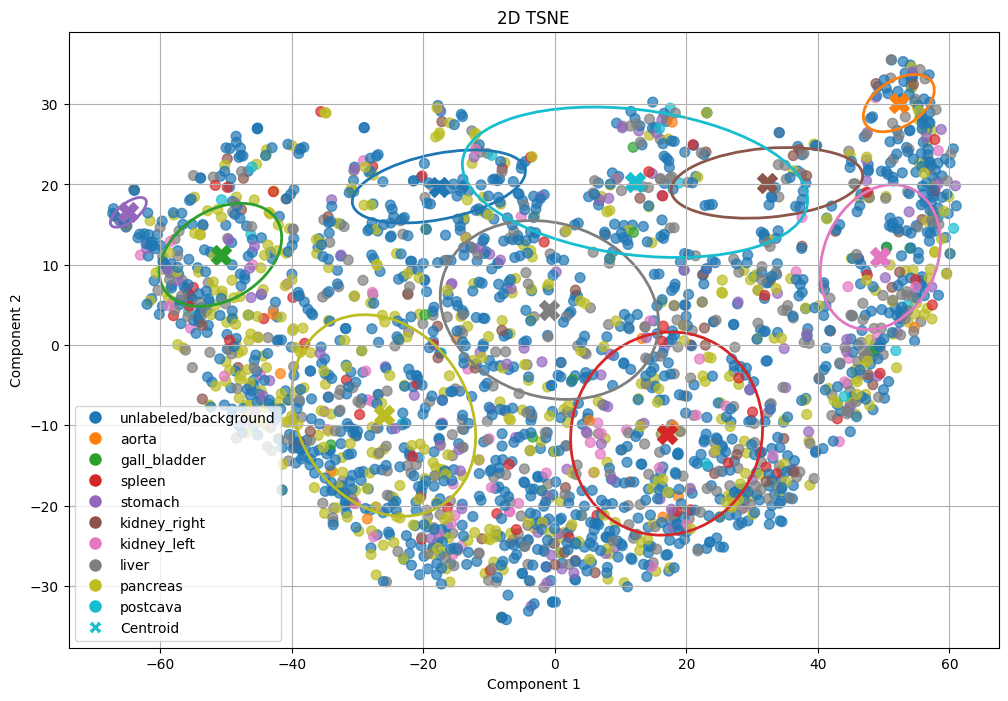

In [76]:
plot_2d(tsne_2d, sampled_points_labels.numpy().flatten(), all_filtered_ids, minibatchkmeans_10.labels_, "2D TSNE")

In [81]:
plot_interactive_3d_scatter(tsne_3d, minibatchkmeans_10.labels_, sampled_points_labels.numpy().flatten(), axis_range=(np.max(tsne_3d),np.max(tsne_3d),np.max(tsne_3d)))

## On PCA, keeping all 8 components

In [63]:
from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

### Only Using middle vectors

I.e. vectors with coordinates $(12,12,12)$ within the encoded $24^3$

In [64]:
middle_vecs, indices = extract_middle_vectors(pca_8_features, n_samples=all_encoded_cubes.shape[0])

middle_vecs.shape

(2530, 8)

In [65]:
features = middle_vecs

In [72]:
minibatchkmeans_10.fit(features)
minibatchkmeans_6.fit(features)
minibatchkmeans_2.fit(features)
minibatchkmeans_4.fit(features)
minibatchkmeans_8.fit(features)
minibatchkmeans_12.fit(features)
minibatchkmeans_14.fit(features)

optics.fit(features)
dbscan.fit(features)

DBSCAN()

In [70]:
pd.DataFrame(optics.labels_[:55]).value_counts()

0  
-1     53
 8      1
 10     1
Name: count, dtype: int64

In [73]:
pd.DataFrame(dbscan.labels_[:55]).value_counts()

0 
 0    32
-1    23
Name: count, dtype: int64

In [56]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_clusters_mini10 = minibatchkmeans_10.labels_[:55]

In [57]:
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


### On Full $24^3$

In [26]:
# Put your best clustering algorithm here

from sklearn.cluster import MiniBatchKMeans

minibatchkmeans_10 = MiniBatchKMeans(n_clusters=10, random_state=42)
minibatchkmeans_6 = MiniBatchKMeans(n_clusters=6, random_state=42)
minibatchkmeans_2 = MiniBatchKMeans(n_clusters=2, random_state=42)
minibatchkmeans_4 = MiniBatchKMeans(n_clusters=4, random_state=42)
minibatchkmeans_8 = MiniBatchKMeans(n_clusters=8, random_state=42)
minibatchkmeans_12 = MiniBatchKMeans(n_clusters=12, random_state=42)
minibatchkmeans_14 = MiniBatchKMeans(n_clusters=14, random_state=42)

In [27]:
flattened_encoded_cts = flatten_features(all_encoded_cubes)

flattened_encoded_cts_scaled = StandardScaler().fit_transform(flattened_encoded_cts)

from sklearn.decomposition import PCA

pca_8_features = PCA().fit_transform(flattened_encoded_cts_scaled)

minibatchkmeans_10.fit(pca_8_features)
minibatchkmeans_6.fit(pca_8_features)
minibatchkmeans_2.fit(pca_8_features)
minibatchkmeans_4.fit(pca_8_features)
minibatchkmeans_8.fit(pca_8_features)
minibatchkmeans_12.fit(pca_8_features)
minibatchkmeans_14.fit(pca_8_features)

MiniBatchKMeans(n_clusters=14, random_state=42)

In [28]:
pca_8_features.shape

(34974720, 8)

In [31]:
cluster_labels_mini10 = minibatchkmeans_10.labels_[indices]
cluster_labels_mini6 = minibatchkmeans_6.labels_[indices]
cluster_labels_mini2 = minibatchkmeans_2.labels_[indices]
cluster_labels_mini4 = minibatchkmeans_4.labels_[indices]
cluster_labels_mini8 = minibatchkmeans_8.labels_[indices]
cluster_labels_mini12 = minibatchkmeans_12.labels_[indices]
cluster_labels_mini14 = minibatchkmeans_14.labels_[indices]

cluster_labels_mini10.shape

(2530,)

In [32]:
first_ct_sampled_points_coordinates = sampled_points_coordinates[0]

first_ct_sampled_points_coordinates.shape

torch.Size([55, 3])

In [33]:
first_ct_id = all_filtered_ids[0]

#### Save Clusters as Landmarks for ITK-SNAP

In [36]:
first_ct_clusters_mini10 = cluster_labels_mini10[:55]

In [37]:
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), first_ct_clusters_mini10, filename='minibatchKmeans_10clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_10clusters.annot'.


In [41]:
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini6, filename='minibatchKmeans_6clusters.annot', slice_range=5)
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini2, filename='minibatchKmeans_2clusters.annot', slice_range=5)
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini4, filename='minibatchKmeans_4clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_6clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_2clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_4clusters.annot'.


In [45]:
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini8, filename='minibatchKmeans_8clusters.annot', slice_range=5)
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini12, filename='minibatchKmeans_12clusters.annot', slice_range=5)
save_clusters_as_annot_all_planes(first_ct_sampled_points_coordinates.numpy(), cluster_labels_mini14, filename='minibatchKmeans_14clusters.annot', slice_range=5)

Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_8clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_12clusters.annot'.
Successfully saved 1815 LandmarkAnnotations to 'minibatchKmeans_14clusters.annot'.


#### Simply plot Sampled Coordinates and their Clusters in Interactive 3D

In [ ]:
import nibabel as nib
import os

first_ct_raw = nib.load(os.path.join('data/healthy-pancreas', first_ct_id, 'ct.nii.gz')).get_fdata()

In [143]:
first_ct_raw.shape

(403, 313, 201)

In [47]:
cluster_labels_mini10

array([5, 1, 8, 8, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 5, 1, 8, 1, 1, 8, 3, 5,
       6, 7, 3, 3, 3, 6, 3, 3, 3, 8, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 5, 3,
       8, 5, 8, 4, 8, 5, 8, 1, 8, 1, 8], dtype=int32)

In [46]:
plot_interactive_3d_scatter(first_ct_sampled_points_coordinates.numpy(), cluster_labels=cluster_labels_mini10, axis_range=first_ct_raw.shape)

In [48]:
pd.DataFrame(cluster_labels_mini10).value_counts()

0
1    22
8    11
3    10
5     7
6     2
2     1
4     1
7     1
Name: count, dtype: int64

##### 3D CT plot looks horrific. Never do it again

## Labels: Pancreatic vs. Non-Pancreatic sampled point

The $96^3$ cube is labeled as "pancreatic" vs. not based on the location of its center point. If it's within the pancreas segmentation mask, it's labeled as "pancreatic".

### First 2 and 3 Components

### Only Middle Vectors

I.e. out of the $24^3$, plotting only point with coordinates $(12, 12, 12)$

In [ ]:
import numpy as np
from sklearn.cluster import OPTICS


# Initialize OPTICS
optics = OPTICS()#min_samples=50, xi=0.05, min_cluster_size=0.1)

# Fit the model
optics.fit(middle_vectors)

# Retrieve cluster labels
cluster_labels = optics.labels_

# Add cluster labels to a DataFrame for easier handling
middle_vectors_df['OPTICS_Clusters'] = cluster_labels

# Display cluster assignments
print(middle_vectors_df.head())

In [ ]:
np.all(cluster_labels == -1)

In [ ]:
pd.DataFrame(cluster_labels_mini10).value_counts()

In [ ]:
pd.DataFrame(cluster_labels).value_counts()

In [ ]:
plot_3d(middle_vectors_df)

### Datashader Plotting 10 clusters on the PCA-ed features

In [ ]:
import holoviews as hv
from holoviews.operation.datashader import datashade
import datashader as ds
from bokeh.palettes import Category10, Category20, viridis
hv.extension('bokeh')

# Define color palette based on the number of unique clusters
unique_clusters = sorted(df_pca['Cluster'].unique())
num_clusters = len(unique_clusters)

if num_clusters <= 10:
    palette = Category10[10]
elif num_clusters <= 20:
    palette = Category20[20]
else:
    palette = viridis(num_clusters)

# Create a categorical color map
color_key = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

# Create HoloViews Points element with 'Cluster' as a categorical dimension
points = hv.Points(df_pca, ['PC1', 'PC2'], 'Cluster')

# Apply Datashader with the defined color map and appropriate aggregator
shaded = datashade(
    points, 
    cmap=palette, 
    aggregator=ds.count_cat('Cluster'),  # Aggregate counts per cluster
).opts(
    width=800,
    height=600,
    title='KMeans Clusters on First Two Principal Components'
)

# Display the plot
shaded

##### <font color='orange'> 3D non-datashader: This is gonna take forever</font>

Datashader doesn't support 3D plots. This means very slow projection

## Labels: Healthy vs. Unhealthy CT

In [ ]:
patient_ids = healthy_patient_ids + panc_patient_ids
labels = labels.tolist()

### Plotting all (38M, 8) vectors

Using 2D PCA features

In [ ]:
# Results for PCA on (50, 55, 8, 24, 24, 24), 8

from matplotlib import pyplot as plt

plt.scatter(pca_results[:, 0], pca_results[:, 1], c=labels, cmap='viridis', s=1)

#### Same Plot but Much Faster - holoview, bokeh

In [ ]:
pca_solver_2d = PCA(n_components=2, random_state=42)

pca_results = pca_solver_2d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
hv.extension('bokeh')  # Initialize HoloViews with the Bokeh backend
import datashader as ds
from holoviews.operation.datashader import datashade
from sklearn.decomposition import PCA
import pandas as pd
from bokeh.palettes import Category10, Category20


# Create a DataFrame
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

df['Label'] = labels.numpy().astype(str)  # Convert labels to string for categorical coloring

# Define color palette
unique_labels = df['Label'].unique()
num_labels = len(unique_labels)
palette = Category10[10] if num_labels <= 10 else Category20[20]

# Create a color key mapping each label to a color
color_key = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

# Create HoloViews Points with 'Label' as a categorical dimension
points = hv.Points(df, ['PC1', 'PC2'], ['Label'])

# Apply Datashader with the color_key
shaded = datashade(points, cmap=color_key, how='log', aggregator=ds.count_cat('Label')).opts(
    width=800,  # Set the width
    height=600  # Set the height
)

# Display the shaded plot
shaded

In [35]:
from sklearn.decomposition import PCA

pca_solver_3d = PCA(n_components=3, random_state=42)

pca_results_3d = pca_solver_3d.fit_transform(flattened_features)

In [ ]:
import holoviews as hv
import pandas as pd
import numpy as np
import plotly.io as pio

# Initialize HoloViews with the Plotly backend
hv.extension('plotly')

# Assuming you have 3 PCA components and labels
# Generate some random PCA data for illustration
pca_results = np.random.rand(1000, 3)  # Replace with your actual PCA results
labels = np.random.randint(0, 5, size=1000)  # Replace with your actual labels

# Create a DataFrame with PCA results and labels
df = pd.DataFrame(pca_results, columns=['PC1', 'PC2', 'PC3'])
df['Label'] = labels.astype(str)  # Convert labels to string for categorical coloring

# Create a 3D scatter plot using HoloViews and Plotly
scatter = hv.Scatter3D(df, kdims=['PC1', 'PC2', 'PC3'], vdims='Label').opts(
    color='Label',  # Color based on Label
    cmap='Category10',  # Choose a colormap for the labels
    size=5,  # Set marker size
    width=800,  # Set width of the plot
    height=600,  # Set height of the plot
    marker='circle',  # Set marker type
    title="3D PCA Scatter Plot"  # Add a title
)

# Display the 3D plot
scatter

### Hyperparameter Search Plots

#### Best PCA

First, perform best clustering - need to find optimal hyperparameters above

<font color='cyan'>From Excel spreadsheet, best choice was: PCA - 36 components - 6 clusters AND T-SNE: 7 clusters, learning_rate	n_components	n_iter	perplexity 10	42	1000	50</font>

In [19]:
from sklearn.decomposition import PCA

best_PCA = PCA(n_components=36, random_state=42)

best_pca_features = best_PCA.fit_transform(flattened_features_std)

In [20]:
from sklearn.cluster import KMeans

best_pca_clustering = KMeans(n_clusters=7, random_state=42)

In [ ]:
best_pca_clusters = best_pca_clustering.fit_predict(best_pca_features)

In [ ]:
best_pca_features.shape

In [ ]:
# --- Plotting the Results ---

# Plot the best unsupervised result in 2D
plot_2d(best_pca_features, labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_pca_features, labels, patient_ids, best_pca_clusters, f'Best Unsupervised Result - PCA - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_pca_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_pca_clusters,
    title='Best Unsupervised Result - PCA - 3D (Interactive)'
)

#### Best T-SNE

In [24]:
from sklearn.manifold import TSNE

best_tsne = TSNE(n_components=42, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')

best_tsne_features = best_tsne.fit_transform(flattened_features_std)

In [ ]:
best_tsne_clustering = KMeans(n_clusters=7, random_state=42)

best_tsne_clusters = best_tsne_clustering.fit_predict(best_tsne_features)

In [ ]:
plot_2d(best_tsne_features, labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

# Plot the best unsupervised result in 3D
plot_3d(best_tsne_features, labels, patient_ids, best_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_tsne_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)',
    plot_axes=True
)

Outlier 5070

![5070.png](mkdown-imgs/5070.png)


Outlier 3427

![3427.png](mkdown-imgs/3427.png)


Outlier 928 - I think this CT is just Shifted from the rest, so it appears as an outlier



![928.png](mkdown-imgs/928.png)

#### T-SNE w/ only 2,3 components (Worse)

In [28]:
best_2d_tsne = TSNE(n_components=2, perplexity=40, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_2d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

best_3d_tsne = TSNE(n_components=3, perplexity=50, learning_rate=10, n_iter=1000, random_state=42, method='exact')
best_3d_tsne_clusterer = KMeans(n_clusters=2, random_state=42)

In [ ]:
best_2d_tsne_features = best_2d_tsne.fit_transform(flattened_features_std)
best_3d_tsne_features = best_3d_tsne.fit_transform(flattened_features_std)

best_2d_tsne_clusters = best_2d_tsne_clusterer.fit_predict(best_2d_tsne_features)
best_3d_tsne_clusters = best_3d_tsne_clusterer.fit_predict(best_3d_tsne_features)

In [ ]:
plot_2d(best_2d_tsne_features, labels, patient_ids, best_2d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 2D')

In [ ]:
best_3d_tsne_features.shape

In [ ]:
plot_3d(best_3d_tsne_features, labels, patient_ids, best_3d_tsne_clusters, f'Best Unsupervised Result - T-SNE - 3D')

In [ ]:
plot_3d_interactive(
    features_high_dim=best_3d_tsne_features,
    labels=labels,
    patient_ids=patient_ids,
    clusters=best_3d_tsne_clusters,
    title='Best Unsupervised Result - T-SNE - 3D (Interactive)')

    

# Supervised Clustering

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
def apply_nca(features, labels, n_components):
    """
    Apply Neighborhood Components Analysis (NCA).

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    nca = NeighborhoodComponentsAnalysis(n_components=n_components, random_state=42)
    nca.fit(features, labels)
    return nca.transform(features)


def apply_pls(features, labels, n_components):
    """
    Apply Partial Least Squares (PLS) regression.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of components to keep.

    Returns:
        numpy.ndarray: Transformed features.
    """
    lb = LabelBinarizer()
    labels_binarized = lb.fit_transform(labels)
    pls = PLSRegression(n_components=n_components)
    pls.fit(features, labels_binarized)
    return pls.transform(features)


def apply_supervised_umap(features, labels, n_components, n_neighbors=15, min_dist=0.1):
    """
    Apply Supervised UMAP.

    Parameters:
        features (numpy.ndarray): Input features.
        labels (numpy.ndarray): Class labels.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        numpy.ndarray: Transformed features.
    """
    reducer = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=42
    )
    return reducer.fit_transform(features, y=labels)

In [ ]:
def evaluate_supervised_methods(features, labels):
    """
    Evaluate clustering with supervised dimensionality reduction methods.

    Parameters:
        features (numpy.ndarray): Scaled features.
        labels (numpy.ndarray): Class labels.

    Returns:
        dict: Results for each method.
    """
    n_components_list = list(range(2, min(features.shape[1], 56), 5))
    n_clusters_list = list(range(2, 8))
    dim_reduction_methods = ['NCA', 'PLS', 'Supervised UMAP']
    clustering_methods = ['kmeans', 'agglomerative', 'gmm']
    
    results = {}
    
    for method in dim_reduction_methods:
        print(f"\nDimensionality Reduction Method: {method}")
        results[method] = {}
        for n_components in n_components_list:
            print(f"  n_components = {n_components}")
            if method == 'NCA':
                try:
                    transformed_features = apply_nca(features, labels, n_components)
                except Exception as e:
                    print(f"    NCA failed at n_components={n_components}: {e}")
                    continue
            elif method == 'PLS':
                try:
                    transformed_features = apply_pls(features, labels, n_components)
                except Exception as e:
                    print(f"    PLS failed at n_components={n_components}: {e}")
                    continue
            elif method == 'Supervised UMAP':
                transformed_features = apply_supervised_umap(features, labels, n_components)
            
            results_key = f"n_components_{n_components}"
            results[method][results_key] = pd.DataFrame(
                index=n_clusters_list,
                columns=clustering_methods
            )
            
            for n_clusters in n_clusters_list:
                for cluster_method in clustering_methods:
                    evaluation = cluster_and_evaluate(
                        transformed_features,
                        method=cluster_method,
                        n_clusters=n_clusters
                    )
                    # Store Silhouette Score
                    results[method][results_key].loc[n_clusters, cluster_method] = evaluation['Silhouette Score']
        print("  Evaluation complete.")
    return results

In [ ]:
supervised_results = evaluate_supervised_methods(flattened_features_std, labels)

In [ ]:
for method, n_components_dict in supervised_results.items():
    print(f"\nResults for {method}:\n")
    for n_components, df in n_components_dict.items():
        print(f"{n_components}")
        print(df)
        print("\n")

Based on the Silhouette Scores, the best clustering result is:

	•	Dimensionality Reduction Method: Supervised UMAP
	•	Number of Components (n_components): 17
	•	Clustering Method: K-Means
	•	Number of Clusters (n_clusters): 2
	•	Silhouette Score: 0.959937


Saving that as a TSV for Projector.tensorflow.org

# Code for Saving for projector.tensorflow.org

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans

cluster_assignments = best_pca_clusters

def save_to_projector_tensorflow_tsv(embedding, cluster_assignments, labels, save_name=""):
    # Prepare data for TSV files
    # Create a DataFrame for the embedding
    embedding_df = pd.DataFrame(embedding)

    # Add cluster assignments and true labels
    embedding_df['Cluster'] = cluster_assignments
    embedding_df['Label'] = labels  # Ensure 'labels' is an array-like object

    feature_save_name = os.path.join("tsv_projections", f'features_{save_name}.tsv')
    metadata_save_name = os.path.join("tsv_projections", f'metadata_{save_name}.tsv')

    # Save the embedding vectors (without Cluster and Label columns)
    embedding_df.drop(columns=['Cluster', 'Label']).to_csv(feature_save_name, sep='\t', index=False, header=False)
    print(f"Embedding vectors saved to {feature_save_name}")

    # Save the metadata (Cluster assignments and Labels)
    metadata_df = embedding_df[['Cluster', 'Label']]
    metadata_df.to_csv(metadata_save_name, sep='\t', index=False)
    print(f"Metadata saved to {metadata_save_name}")

In [ ]:
save_to_projector_tensorflow_tsv(best_pca_features, best_pca_clusters, labels, save_name="best_pca")

In [ ]:
save_to_projector_tensorflow_tsv(best_tsne_features, best_tsne_clusters, labels, save_name="best_tsne")

In [ ]:
save_to_projector_tensorflow_tsv(best_2d_tsne_features, best_2d_tsne_clusters, labels, save_name="best_2d_tsne")

In [ ]:
save_to_projector_tensorflow_tsv(best_3d_tsne_features, best_3d_tsne_clusters, labels, save_name="best_3d_tsne")